In [1]:
!pip install tensorboard_logger

In [2]:
import numpy as np
import pandas as pd
import zipfile
import glob
from PIL import Image
import copy
import random
from time import time
from typing import Any, Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
from torch.autograd import Variable
import time as t
plt.switch_backend('agg')
import os

from tensorboard_logger import Logger
from torchvision import utils

In [ ]:
!unzip drive/MyDrive/archive.zip
# https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset dataset link

In [4]:
!mkdir -p images/dog
!mv PetImages/Dog/*.jpg images/dog/
#!mkdir -p images/cat
#!mv PetImages/Cat/*.jpg images/cat/




In [5]:

!find images/dog -type f ! \( -name "*.jpg" \) -exec rm {} \;
#!find images/cat -type f ! \( -name "*.jpg" \) -exec rm {} \;


In [6]:
import os
from PIL import Image, UnidentifiedImageError

# Directory containing the images
image_directory = "images/dog"

# Loop through each file in the directory
for filename in os.listdir(image_directory):
    file_path = os.path.join(image_directory, filename)

    # Skip directories, only process files
    if os.path.isfile(file_path):
        try:
            # Attempt to open the image
            with Image.open(file_path) as img:
                # You can insert any additional processing here if needed
                pass
        except UnidentifiedImageError:
            print(f"Deleting non-image or corrupted file: {file_path}")
            os.remove(file_path)
        except IOError:
            print(f"IOError for file: {file_path}")

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Deleting non-image or corrupted file: images/dog/11702.jpg


In [ ]:
# Directory containing the images
image_directory = "images/cat"

# Loop through each file in the directory
for filename in os.listdir(image_directory):
    file_path = os.path.join(image_directory, filename)

    # Skip directories, only process files
    if os.path.isfile(file_path):
        try:
            # Attempt to open the image
            with Image.open(file_path) as img:
                # You can insert any additional processing here if needed
                pass
        except UnidentifiedImageError:
            print(f"Deleting non-image or corrupted file: {file_path}")
            os.remove(file_path)
        except IOError:
            print(f"IOError for file: {file_path}")

In [9]:
# Make data set with resized and normalized
image_size = 64
dataset = torchvision.datasets.ImageFolder(
    root = "images",
    transform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),
         transforms.CenterCrop(image_size),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [10]:
image_shape = dataset[0][0].shape
image_shape

torch.Size([3, 64, 64])

In [17]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(image_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *image_shape)
        return img


In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(image_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [13]:
# Initialize generator and discriminator
cuda = True if torch.cuda.is_available() else False
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [14]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [15]:
lr = 0.00005
b1 = 0.5
b2 = 0.999
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [19]:
from torchvision.utils import save_image
for epoch in range(100):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 100, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 400 == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/100] [Batch 0/390] [D loss: 0.670391] [G loss: 0.709216]
[Epoch 0/100] [Batch 1/390] [D loss: 0.633917] [G loss: 0.708671]
[Epoch 0/100] [Batch 2/390] [D loss: 0.634783] [G loss: 0.708154]
[Epoch 0/100] [Batch 3/390] [D loss: 0.620865] [G loss: 0.707554]
[Epoch 0/100] [Batch 4/390] [D loss: 0.574231] [G loss: 0.706589]
[Epoch 0/100] [Batch 5/390] [D loss: 0.565080] [G loss: 0.705912]
[Epoch 0/100] [Batch 6/390] [D loss: 0.527584] [G loss: 0.705905]
[Epoch 0/100] [Batch 7/390] [D loss: 0.517601] [G loss: 0.704190]
[Epoch 0/100] [Batch 8/390] [D loss: 0.523318] [G loss: 0.703857]
[Epoch 0/100] [Batch 9/390] [D loss: 0.479634] [G loss: 0.703205]
[Epoch 0/100] [Batch 10/390] [D loss: 0.480999] [G loss: 0.702314]
[Epoch 0/100] [Batch 11/390] [D loss: 0.504657] [G loss: 0.701509]
[Epoch 0/100] [Batch 12/390] [D loss: 0.466738] [G loss: 0.700671]
[Epoch 0/100] [Batch 13/390] [D loss: 0.472854] [G loss: 0.702678]
[Epoch 0/100] [Batch 14/390] [D loss: 0.486235] [G loss: 0.700107]
[Epoc

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


流式输出内容被截断，只能显示最后 5000 行内容。
[Epoch 87/100] [Batch 70/390] [D loss: 0.382046] [G loss: 1.572512]
[Epoch 87/100] [Batch 71/390] [D loss: 0.361438] [G loss: 1.794890]
[Epoch 87/100] [Batch 72/390] [D loss: 0.423198] [G loss: 1.515983]
[Epoch 87/100] [Batch 73/390] [D loss: 0.483870] [G loss: 1.508874]
[Epoch 87/100] [Batch 74/390] [D loss: 0.443240] [G loss: 1.852196]
[Epoch 87/100] [Batch 75/390] [D loss: 0.558395] [G loss: 1.577049]
[Epoch 87/100] [Batch 76/390] [D loss: 0.484860] [G loss: 1.843191]
[Epoch 87/100] [Batch 77/390] [D loss: 0.453134] [G loss: 1.532530]
[Epoch 87/100] [Batch 78/390] [D loss: 0.425464] [G loss: 1.320220]
[Epoch 87/100] [Batch 79/390] [D loss: 0.376272] [G loss: 1.590254]
[Epoch 87/100] [Batch 80/390] [D loss: 0.430377] [G loss: 1.634119]
[Epoch 87/100] [Batch 81/390] [D loss: 0.548799] [G loss: 1.457614]
[Epoch 87/100] [Batch 82/390] [D loss: 0.591909] [G loss: 1.302287]
[Epoch 87/100] [Batch 83/390] [D loss: 0.383693] [G loss: 1.549885]
[Epoch 87/100] [Batch

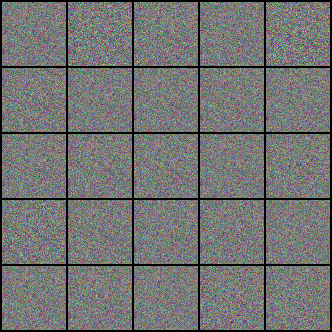

In [22]:
from IPython.display import Image
Image(filename='images/0.png')

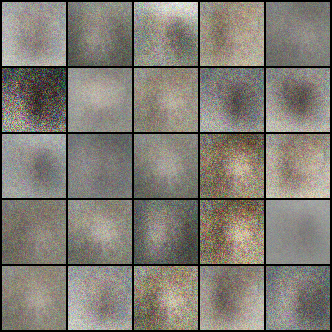

In [21]:
from IPython.display import Image
Image(filename='images/1200.png')

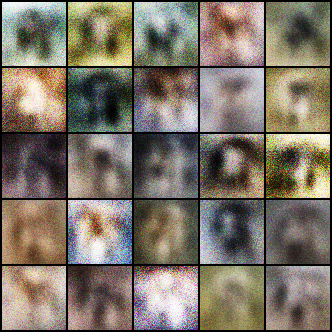

In [23]:
Image(filename='images/10000.png')

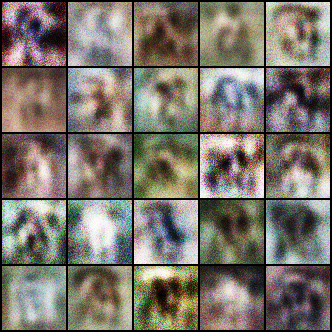

In [24]:
Image(filename='images/20000.png')

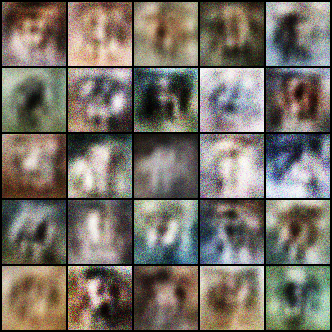

In [26]:
Image(filename='images/25200.png')

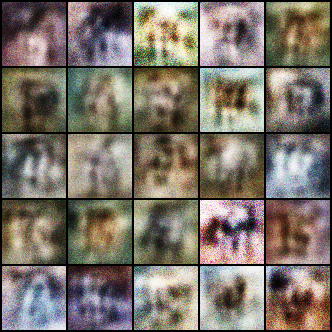

In [27]:
Image(filename='images/30000.png')

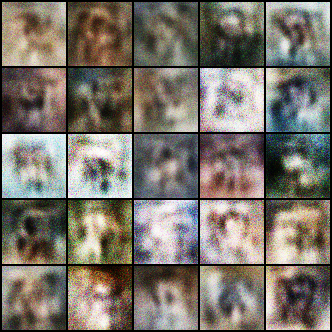

In [28]:
Image(filename='images/32000.png')

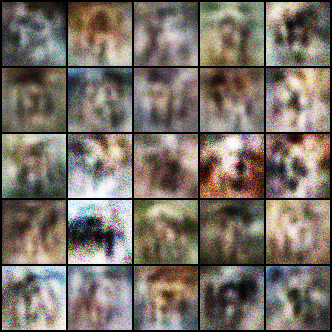

In [29]:
Image(filename='images/38800.png')